<img src="https://github.com/djp840/MSDS_458_Public/blob/main/images2/NorthwesternHeader.png?raw=1" />

## MSDS458 Research Assignment 3 - Part 01 LSTM 

### Analyze AG_NEWS_SUBSET Data <br>

AG is a collection of more than 1 million news articles. News articles have been gathered from more than 2000 news sources by ComeToMyHead in more than 1 year of activity. ComeToMyHead is an academic news search engine which has been running since July, 2004. The dataset is provided by the academic comunity for research purposes in data mining (clustering, classification, etc), information retrieval (ranking, search, etc), xml, data compression, data streaming, and any other non-commercial activity.<br> 

For more information, please refer to the link http://www.di.unipi.it/~gulli/AG_corpus_of_news_articles.html<br> 


The AG's news topic classification dataset is constructed by choosing 4 largest classes (**World**, **Sports**, **Business**, and **Sci/Tech**) from the original corpus. Each class contains 30,000 training samples and 1,900 testing samples. The total number of training samples is 120,000 and testing 7,600.<br>

Homepage: https://arxiv.org/abs/1509.01626<br>

Source code: tfds.text.AGNewsSubset

Versions:

1.0.0 (default): No release notes.
Download size: 11.24 MiB

Dataset size: 35.79 MiB

### References
1. Deep Learning with Python, Francois Chollet (https://learning.oreilly.com/library/view/deep-learning-with/9781617296864/)
 * Chapter 10: Deep learning for time series
 * Chapter 11: Deep learning for text
2. Deep Learning A Visual Approach, Andrew Glassner (https://learning.oreilly.com/library/view/deep-learning/9781098129019/)
 * Chapter 19: Recurrent Neural Networks
 * Chapter 20: Attention and Transformers

### Processing words as a sequence: The sequence model approach

To implement a sequence model, you’d start by representing your input samples as sequences of integer indices (one integer standing for one word). Then, you’d map each integer to a vector to obtain vector sequences. Finally, you’d feed these sequences of vectors into a stack of layers that could cross-correlate features from adjacent vectors, such as a 1D convnet, a RNN, or a Transformer.

For some time around 2016–2017, bidirectional RNNs (in particular, `bidirectional LSTMs`) were considered to be the state of the art for sequence modeling. However, nowadays sequence modeling is almost universally done with `Transformers`. 

F. Chollet: "One-dimensional convnets were never very popular in NLP, even though, a residual stack of depthwise-separable 1D convolutions can often achieve comparable performance to a bidirectional LSTM, at a greatly reduced computational cost."

### Import Packages

In [1]:
from packaging import version
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import string

import seaborn as sns
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow.keras.backend as k

import nltk
from nltk.corpus import stopwords

### Verify TensorFlow version and Keras version

In [2]:
print("This notebook requires TensorFlow 2.0 or above")
print("TensorFlow version: ", tf.__version__)
assert version.parse(tf.__version__).release[0] >=2

This notebook requires TensorFlow 2.0 or above
TensorFlow version:  2.8.0


In [3]:
print("Keras version: ", keras.__version__)

Keras version:  2.8.0


### Stopword Function

In [4]:
def custom_stopwords(input_text):
    lowercase = tf.strings.lower(input_text)
    stripped_punct = tf.strings.regex_replace(lowercase
                                  ,'[%s]' % re.escape(string.punctuation)
                                  ,'')
    return tf.strings.regex_replace(stripped_punct, r'\b(' + r'|'.join(STOPWORDS) + r')\b\s*',"")

### Plotting Model Performance Metrics 

In [5]:
def display_training_curves(training, validation, title, subplot):
  ax = plt.subplot(subplot)
  ax.plot(training)
  ax.plot(validation)
  ax.set_title('model '+ title)
  ax.set_ylabel(title)
  ax.set_xlabel('epoch')
  ax.legend(['training', 'validation'])

def print_validation_report(test_labels, predictions):
    print("Classification Report")
    print(classification_report(test_labels, predictions))
    print('Accuracy Score: {}'.format(accuracy_score(test_labels, predictions)))
    print('Root Mean Square Error: {}'.format(np.sqrt(MSE(test_labels, predictions)))) 
    
def plot_confusion_matrix(y_true, y_pred):
    mtx = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(16,12))
    sns.heatmap(mtx, annot=True, fmt='d', linewidths=.75,  cbar=False, ax=ax,cmap='Blues',linecolor='white')
    #  square=True,
    plt.ylabel('true label')
    plt.xlabel('predicted label')

### Mount Google Drive to Colab environment

In [6]:
#from google.colab import drive
#drive.mount('/content/gdrive')

### Load Data

In [7]:
# register  ag_news_subset so that tfds.load doesn't generate a checksum (mismatch) error
!python -m tensorflow_datasets.scripts.download_and_prepare --register_checksums --datasets=ag_news_subset

dataset,info=\
tfds.load('ag_news_subset', with_info=True,  split=['train[:95%]','train[95%:]', 'test'],batch_size = 32
          , as_supervised=True)

train_ds, val_ds, test_ds = dataset
text_only_train_ds = train_ds.map(lambda x, y: x)

2023-03-17 17:06:38.465330: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-03-17 17:06:38.465371: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2023-03-17 17:06:41.043036: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-03-17 17:06:41.043068: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2023-03-17 17:06:41.043093: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (ub3): /proc/driver/nvidia/version does not exist
W0317 17:06:41.043231 140182781908800 download_and_prepare.py:42] ***`tfd

### Preparing Integer Sequence Datasets

In [8]:
nltk.download('stopwords',quiet=True)
STOPWORDS = stopwords.words("english")

In [9]:
max_length = 96
max_tokens = 1000
text_vectorization = layers.TextVectorization(
    max_tokens=max_tokens,
    output_mode="int",
    output_sequence_length=max_length,
    standardize=custom_stopwords
)
text_vectorization.adapt(text_only_train_ds)

int_train_ds = train_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_val_ds = val_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)
int_test_ds = test_ds.map(
    lambda x, y: (text_vectorization(x), y),
    num_parallel_calls=4)

### Bi-directional RNN

When translating in real-time, it would help to have access to worlds towards the end of a sentence, say, as well as earlier words in the sentence. One way to use the later words in the sentence is to feed the words into our RNN backward. So if we create two independent RNNs, we can feed one the words in their forward, or natural order, and the second gets their words in the revser order. This is the idea behind `Bi-directional RNNS`:

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/BidirectionalRNN.png?raw=1">

### Understanding word embeddings

When you encode something via `one-hot encoding`, you’re making a feature-engineering decision. You’re injecting into your model a fundamental assumption about the structure of your feature space. That assumption is that the different tokens you’re encoding are all independent from each other: indeed, one-hot vectors are all orthogonal to one another.

However, in a reasonable word vector space, you would expect synonyms to be embedded into similar word vectors, and in general, you would expect the geometric distance  between any two word vectors to relate to the “semantic distance” between the associated words.

Words that mean different things should lie far away from each other, whereas related words should be closer.

`Word embeddings` are vector representations of words that achieve exactly this: they map human language into a structured geometric space.

Whereas the vectors obtained through `one-hot encoding` are *binary*, *sparse*, and *very high-dimensional* (the same dimensionality as the number of words in the vocabulary), `word embeddings` are *low-dimensional floating-point vectors* (that is, `dense vectors`, as opposed to `sparse vectors`).

<img src="https://github.com/djp840/MSDS_458_Public/blob/master/images/EmbeddingsSparse.png?raw=1">

### Two ways to obtain word embeddings

1. `Learn word embeddings jointly with the main task you care about` (such as document classification or sentiment prediction). In this setup, you start with random word vectors and then learn word vectors in the same way you learn the weights of a neural network.
2. Load into your model word embeddings that were precomputed using a different machine learning task than the one you’re trying to solve. These are called `pretrained word embeddings`.


<div class="alert alert-block alert-success"><b>tf.keras.layers.Embedding</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Embedding </div>

### Understanding Padding and Masking

One thing that’s slightly hurting model performance here is that our input sequences are full of zeros. This comes from our use of the `output_sequence_length=max_ length` option in TextVectorization (with `max_length equal` to 150): sentences longer than 150 tokens are truncated to a length of 150 tokens, and sentences shorter than 150 tokens are padded with zeros at the end so that they can be concatenated together with other sequences to form contiguous batches.

The RNN that looks at the tokens in their natural order will spend its last iterations seeing only vectors that encode padding—possibly for several hundreds of iterations if the original sentence was short. The information stored in the internal state of the RNN will gradually fade out as it gets exposed to these meaningless inputs.

We need some way to tell the RNN that it should skip these iterations. There’s an API for that: `masking`.

<div class="alert alert-block alert-success"><b>tf.keras.layers.Masking</b><br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Masking</div>

### Model Leveraging Embedding Layer With Masking Enabled

In [10]:
k.clear_session()
inputs = tf.keras.Input(shape=(None,), dtype="int64")
embedded = layers.Embedding(input_dim=max_tokens
                            ,output_dim=256
                            ,mask_zero=True)(inputs)
x = layers.Bidirectional(layers.LSTM(32))(embedded)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(4, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop",
              loss="SparseCategoricalCrossentropy",
              metrics=["accuracy"])
model.summary()

callbacks = [
    tf.keras.callbacks.ModelCheckpoint("LSTM.h5",save_best_only=True)
    ,tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=3)
]
history=model.fit(int_train_ds, validation_data=int_val_ds, epochs=200, callbacks=callbacks)
model = keras.models.load_model("LSTM.h5")
print(f"Test acc: {model.evaluate(int_test_ds)[1]:.3f}")

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None)]            0         
                                                                 
 embedding (Embedding)       (None, None, 256)         256000    
                                                                 
 bidirectional (Bidirectiona  (None, 64)               73984     
 l)                                                              
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense (Dense)               (None, 4)                 260       
                                                                 
Total params: 330,244
Trainable params: 330,244
Non-trainable params: 0
_______________________________________________________

### Post Modeling Metrics

In [11]:
history_dict = history.history
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [12]:
losses = history.history['loss']
accs = history.history['accuracy']
val_losses = history.history['val_loss']
val_accs = history.history['val_accuracy']
epochs = len(losses)
history_df=pd.DataFrame(history_dict)
history_df.tail().round(3)

,loss,accuracy,val_loss,val_accuracy
1,0.415,0.855,0.392,0.862
2,0.401,0.860,0.387,0.869
3,0.389,0.862,0.387,0.867
4,0.381,0.867,0.384,0.868
5,0.374,0.869,0.383,0.868


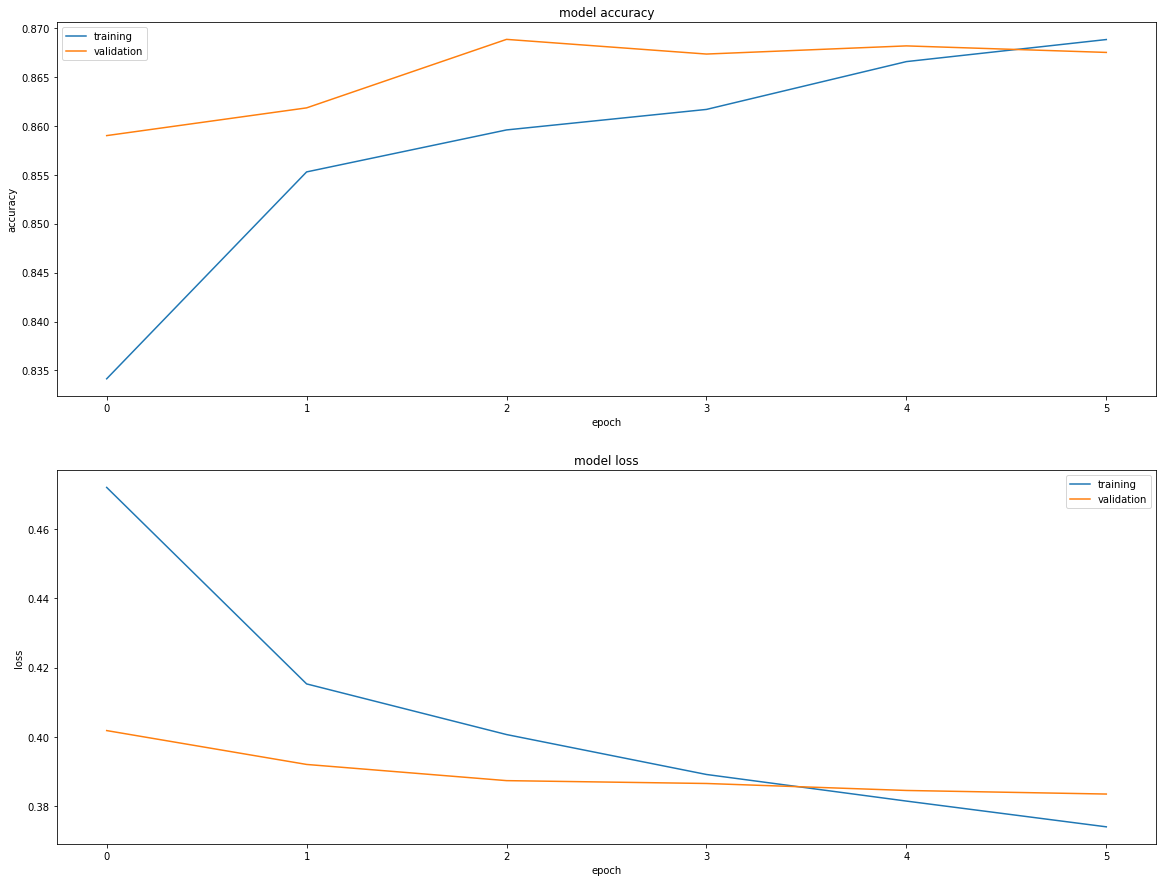

In [13]:
plt.subplots(figsize=(16,12))
plt.tight_layout()
display_training_curves(history.history['accuracy'], history.history['val_accuracy'], 'accuracy', 211)
display_training_curves(history.history['loss'], history.history['val_loss'], 'loss', 212)

In [14]:
y_test = np.concatenate([y for x, y in int_test_ds], axis=0)
pred_classes = np.argmax(model.predict(int_test_ds), axis=-1)

In [15]:
print_validation_report(y_test, pred_classes)

Classification Report
              precision    recall  f1-score   support

           0       0.88      0.87      0.87      1900
           1       0.92      0.94      0.93      1900
           2       0.85      0.82      0.83      1900
           3       0.82      0.83      0.83      1900

    accuracy                           0.87      7600
   macro avg       0.86      0.87      0.86      7600
weighted avg       0.86      0.87      0.86      7600

Accuracy Score: 0.8651315789473685
Root Mean Square Error: 0.6516174208520631


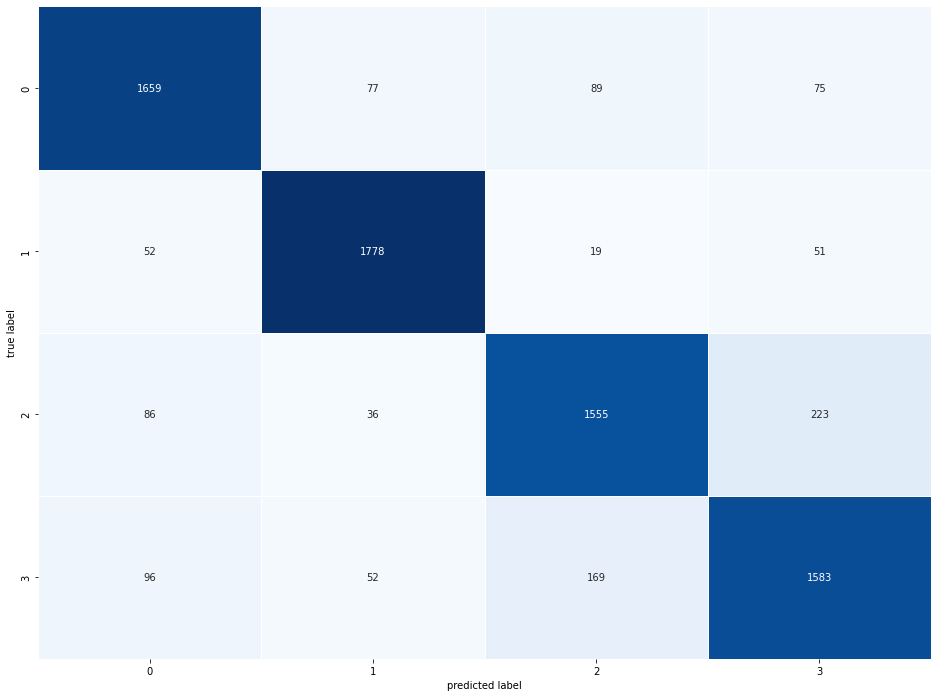

In [16]:
plot_confusion_matrix(y_test,pred_classes)